# Object Detection with Image or Webcam on Ryzen AI

This example demonstrates the object detection model inference on the embedded Neural Processing Unit (NPU) in your AMD Ryzen AI enabled PC with either single image or the live webcam. 

In [ ]:
# Before starting, be sure you've installed the requirements listed in the requirements.txt file:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


### 1. Get Model from Ryzen AI model zoo
The yolov8 model from [Ryzen AI model zoo](https://huggingface.co/amd) will be applied in this example. You may choose any other object detection models with tiny difference in the pre and post processing.

In [ ]:
# Notebook dependencies
from huggingface_hub import hf_hub_download
from yolov8_utils import get_directories

current_dir = get_directories()

# Download Yolov8 model from Ryzen AI model zoo. Registration is required before download.
hf_hub_download(repo_id="amd/yolov8m", filename="yolov8m.onnx", local_dir=str(current_dir))


EntryNotFoundError: 404 Client Error. (Request ID: Root=1-67c39ee0-3eeac3001f41654b6e7676cf;6e944ac6-2f37-41ea-b651-6cbc026512ee)

Entry Not Found for url: https://huggingface.co/hibalaz/trash-detection-model/resolve/main/seegull.onnx.

### 3. Model inference on NPU with webcam

Now we have validated the the model with image., and we will use the webcam as live input to do the inference on NPU.

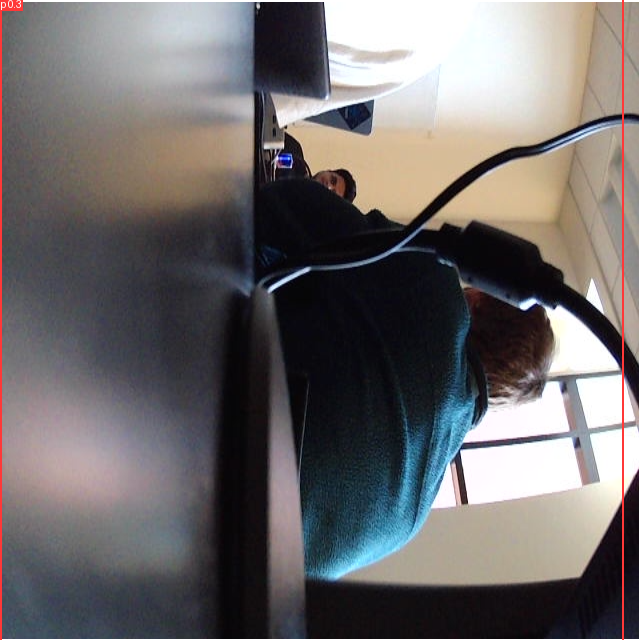

In [ ]:
import torch
import torch.nn as nn
import onnxruntime
import numpy as np
import cv2
from yolov8_utils import *

# display videos in notebook
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML


def frame_process(frame, input_shape=(640, 640)):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, input_shape)
    img = torch.from_numpy(img)
    img = img.float()  # uint8 to fp16/32
    img /= 255  # 0 - 255 to 0.0 - 1.0
    img = np.transpose(img, (2, 0, 1))
    return img
    

class DFL(nn.Module):
    # Integral module of Distribution Focal Loss (DFL) proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    def __init__(self, c1=16):
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(
            b, 4, a
        )


def dist2bbox(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = torch.split(distance, 2, dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return torch.cat((c_xy, wh), dim)  # xywh bbox
    return torch.cat((x1y1, x2y2), dim)  # xyxy bbox


def post_process(x):
    dfl = DFL(16)
    anchors = torch.tensor(
        np.load(
            "./anchors.npy",
            allow_pickle=True,
        )
    )
    strides = torch.tensor(
        np.load(
            "./strides.npy",
            allow_pickle=True,
        )
    )
    box, cls = torch.cat([xi.view(x[0].shape[0], 144, -1) for xi in x], 2).split(
        (16 * 4, 80), 1
    )
    dbox = dist2bbox(dfl(box), anchors.unsqueeze(0), xywh=True, dim=1) * strides
    y = torch.cat((dbox, cls.sigmoid()), 1)
    return y, x

# Load labels of coco dataaset
with open('coco.names', 'r') as f:
        names = f.read()

imgsz = [640, 640]

# Specify the path to the quantized ONNZ Model
onnx_model_path = "yolov8m.onnx"

# Point to the config file path used for the VitisAI Execution Provider
config_file_path = "./vaip_config.json"

npu_options = onnxruntime.SessionOptions()

npu_session = onnxruntime.InferenceSession(
    onnx_model_path,
    providers = ['VitisAIExecutionProvider'],
    sess_options=npu_options,
    provider_options=[{'config_file': config_file_path}]
)

with open('coco.names', 'r') as f:
        names = f.read()

# Video input
cap = cv2.VideoCapture(0)

while (True):
    try:
        clear_output(wait=True)
        ret, frame = cap.read()
        
        if not ret:
            break
            
        input_shape = (640, 640)

        im = frame_process(frame, input_shape)
        if len(im.shape) == 3:
            im = im[None]
        outputs = npu_session.run(None, {npu_session.get_inputs()[0].name: im.permute(0, 2, 3, 1).cpu().numpy()})

        # Postprocessing
        outputs = [torch.tensor(item).permute(0, 3, 1, 2) for item in outputs]
        preds = post_process(outputs)
        preds = non_max_suppression(
            preds, 0.25, 0.7, agnostic=False, max_det=300, classes=None
        )

        colors = [[random.randint(0, 255) for _ in range(3)] 
                for _ in range(len(names))]

        plot_images(
        im,
        *output_to_target(preds, max_det=15),
        frame,
        fname="output.jpg",
        names=names,
        )
        
    except KeyboardInterrupt:
        cap.release()